# Hyperparameter tuning
Dopo aver fatto qualche addestramento di prova, per capire quale fosse la funzione di loss migliore e l'ottimizzatore migliore per il mio modello, passo alla fase di Hyperparameter tuning, in particolare il mio focus va sul learning rate. Proverò diversi valori, a partire da 1e-5 fino a 1e-2 per vedere quale è il migliore. In seguito proverò a fare anche qualche tipo diverso di data augmentation, variado i semplici RandomResizedCrop e CenterCrop che ho fatto finora.

Il modello migliore finora si è rivelato UNET_0, quindi il primo che ho testato. Userò quindi la stessa funzione di loss che è la BCEWithLogitsLoss. La nn.BCEWithLogitsLoss() combina la funzione Sigmoide e la Binary Cross Entropy Loss in un'unica operazione. Questo è fondamentale per la stabilità numerica. 

Da ora continuerò ad aggiornare il file riassunto_modelli.txt a partire dal modello UNET_4, testando i vari learning rate per trovare il migliore. Non ripeterò l'addestramento per i learning rate 1e-5 e 1e-4 che li ho già eseguiti, testerò solamente 1e-3 e 1e-2 per vedere se vanno meglio.

In [30]:
# Importo librerie e moduli necessari
import sys
sys.path.insert(0, './src')
import utils

import albumentations as A
import os
import torch
import torch.nn as nn
import warnings
import torch.utils.data as data
from rasterio.errors import NotGeoreferencedWarning

In [31]:
device = utils.set_cuda_and_seed()

print("PyTorch version: ", torch.__version__)
print("CUDA version: ", torch.version.cuda)
print("cuDNN version: ", torch.backends.cudnn.version())

Using PyTorch version: 2.7.1+cu118  Device: cuda
PyTorch version:  2.7.1+cu118
CUDA version:  11.8
cuDNN version:  90100


In [32]:
MEAN = [0, 0, 0]
STD = [1.0, 1.0, 1.0]
INITIAL_LR = 1e-4 
MAX_LR = 1e-2
SIZE = 200
NUM_WORKERS = 8
BATCH_SIZE = 16 # o 32
EPOCHS = 16
LOAD_BEST = False

# Percorsi utili
DATASET_PATH = "data/train/AOI_11_Rotterdam/"
OUTPUT_PATH = "output/"
CHECKPOINT_PATH = OUTPUT_PATH + "checkpoints/"
GRAPH_PATH = OUTPUT_PATH + "graphs/"
SPLIT_PATH = "split/"

In [33]:
train_transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    # A.RandomResizedCrop(size = (SIZE, SIZE)),
    # Aggiunta di rotazioni e flipping
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    
    # Aggiunta di trasformazioni di Rumore/Distorsione/Occlusione
    A.GaussNoise(p=0.2),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, fill_value=0, p=0.2),
])

eval_transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    A.CenterCrop(SIZE, SIZE)
])

from dataset import SpaceNet6Dataset

train_dataset = SpaceNet6Dataset(SPLIT_PATH, transform=train_transforms, split='train')
eval_dataset = SpaceNet6Dataset(SPLIT_PATH, transform=eval_transforms, split='val')

/tmp/ipykernel_6658/650582428.py:11: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=8, max_width=8, fill_value=0, p=0.2),


Image shape: torch.Size([16, 3, 900, 900]), Mask shape: torch.Size([16, 1, 900, 900])


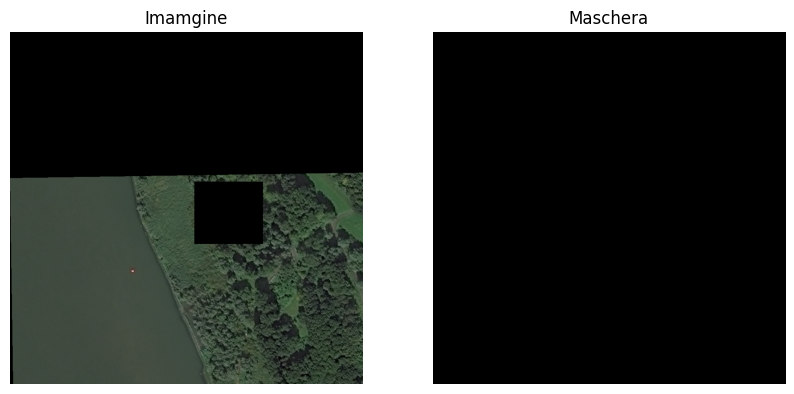

In [34]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

    train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
    eval_loader = data.DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True,  pin_memory=True, num_workers=NUM_WORKERS)

    image, mask = next(iter(train_loader))
    in_channels = image.shape[1]
    out_channels = mask.shape[1]
    print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
    utils.visualize_image(image[0], mask[0])

In [35]:
from model import UNET
from train import train
from torchsummary import summary
import torch.optim as optim

model = UNET(in_channels = 3, out_channels = 1).to(device)

loss_f = nn.BCEWithLogitsLoss() # All'inizio usiamo BCEWithLogitsLoss, poi provo anche una CrossEntropyLoss
optimizer = torch.optim.Adam(model.parameters(), lr=INITIAL_LR)
# optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=0.9, weight_decay=1e-4)

scheduler = None
scaler = torch.amp.GradScaler('cuda', enabled=True)

print("Riepilogo del modello:")
summary(model, input_size=(in_channels, SIZE, SIZE), device=str(device))

print("Modello U-Net inizializzato e spostato sul dispositivo.")

# Ricorda di dare un nome al modello ad ogni esecuzione, che lo identificherà nel file riassuntivo
model_name = "UNET_7"

Riepilogo del modello:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]           1,728
       BatchNorm2d-2         [-1, 64, 200, 200]             128
              ReLU-3         [-1, 64, 200, 200]               0
            Conv2d-4         [-1, 64, 200, 200]          36,864
       BatchNorm2d-5         [-1, 64, 200, 200]             128
              ReLU-6         [-1, 64, 200, 200]               0
        DoubleConv-7         [-1, 64, 200, 200]               0
         MaxPool2d-8         [-1, 64, 100, 100]               0
            Conv2d-9        [-1, 128, 100, 100]          73,728
      BatchNorm2d-10        [-1, 128, 100, 100]             256
             ReLU-11        [-1, 128, 100, 100]               0
           Conv2d-12        [-1, 128, 100, 100]         147,456
      BatchNorm2d-13        [-1, 128, 100, 100]             256
             ReL

In [36]:
# Variabili per i checkpoint
best_f1 = 0.0
history = {
    'train_loss': [],
    'val_loss': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'accuracy': [],
}

last_epoch = 0
if LOAD_BEST:
    print("Ricaricando il modello migliore...")
    if(os.path.exists(CHECKPOINT_PATH + "best.pth")):
        history, last_epoch = utils.load_checkpoint(CHECKPOINT_PATH + "best.pth", model, optimizer, scheduler)
        best_f1 = max(history['f1'])
    else:
        print("Nessun modello trovato, inizio un nuovo training da zero.")


# Ciclo di traininig
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)
    for epoch in range(last_epoch, EPOCHS):
        print(f"Epoch {epoch+1} of {EPOCHS}")
        train_loss = train(train_loader, model, optimizer, loss_f, scaler, scheduler, device)
        # Se la loss è NaN, vuol dire che qualcosa non sta andando come previsto, vado quindi ad interrompere il training.
        # in python il controllo se una variabile è NaN si fa con la condizione `var != var`
        if train_loss != train_loss:
            raise ValueError("La loss è Nan, qualcosa sta andando storto, interrompo il training!")

        eval_loss, precision, recall, f1, accuracy = utils.get_evals(eval_loader, model, loss_f, device, save_predictions=True, output_path="data/eval/" + model_name + "/")
        history['train_loss'].append(train_loss)
        history['val_loss'].append(eval_loss)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1'].append(f1)
        history['accuracy'].append(accuracy)
        print(f"Train loss: {train_loss:.4f} Eval loss: {eval_loss:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f} Accuracy: {accuracy:.4f}")
        # Salvataggio del checkpoint
        checkpoint = {
            "history" : history,
            "epoch" : epoch,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "loss": loss_f.state_dict(),
        }
        utils.save_checkpoint(checkpoint, filename=CHECKPOINT_PATH + "checkpoint.pth")
        if f1 > best_f1:
            best_f1 = f1
            utils.save_checkpoint(checkpoint, filename=CHECKPOINT_PATH + "best.pth")
            print("Best model salvato")

        if epoch - 3 > 0: # Value of validation loss is increasing, model is overfitting. Need to stop training
            if history['val_loss'][epoch] > history['val_loss'][epoch-1] > history['val_loss'][epoch-2]:
                print("Early stopping")
                break
print("Training completato con successo!")

Epoch 1 of 16


  0%|          | 0/170 [00:08<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.55 GiB. GPU 0 has a total capacity of 5.79 GiB of which 1.05 GiB is free. Including non-PyTorch memory, this process has 4.73 GiB memory in use. Of the allocated memory 3.83 GiB is allocated by PyTorch, and 776.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
SUMMARY_FILE_PATH = "output/stats/riassunto_modelli.txt"
epochs_completed = epoch + 1 # Poiché 'epoch' è 0-indexed
final_train_loss = history['train_loss'][-1] # L'ultimo elemento della lista
final_eval_loss = history['val_loss'][-1]   # L'ultimo elemento della lista
loss_function_name = loss_f.__class__.__name__

# Trova l'epoca in cui è stato raggiunto il best_f1
try:
    if history['f1']:
        best_f1_epoch = history['f1'].index(best_f1)
    else:
        best_f1_epoch = 0 # Se la history è vuota, usa 0
except ValueError:
    best_f1_epoch = epochs_completed - 1 if epochs_completed > 0 else 0
    print(f"Attenzione: Impossibile trovare best_f1 ({best_f1:.4f}) nella cronologia. Usando l'epoca {best_f1_epoch} per le metriche.")


final_precision = history['precision'][best_f1_epoch]
final_recall = history['recall'][best_f1_epoch]
final_accuracy = history['accuracy'][best_f1_epoch]

# Prepara le stringhe per configurazione e statistiche
config_str = (
    f"MODEL_NAME={model_name},"
    f"NETWORK_TYPE=UNET,IN_CHANNELS={in_channels},OUT_CHANNELS={out_channels},"
    f"LR={INITIAL_LR},BATCH_SIZE={BATCH_SIZE},OPTIMIZER=Adam,"
    f"LOSS_FUNCTION={loss_function_name}," 
    f"MAX_EPOCHS={EPOCHS}"  
    # Altri parametri da aggiungere
)

stats_str = (
    f"TRAIN_LOSS={final_train_loss:.4f},"
    f"VAL_LOSS={final_eval_loss:.4f},"
    f"BEST_F1={best_f1:.4f},"
    f"PRECISION={final_precision:.4f},"
    f"RECALL={final_recall:.4f},"
    f"ACCURACY={final_accuracy:.4f},"
    f"EPOCH_OF_BEST_F1={best_f1_epoch}" # Aggiungi l'epoca del best F1
    # Altri parametri da aggiungere
)

# Scrittura sul file di riepilogo
with open(SUMMARY_FILE_PATH, 'a') as f:
    f.write(f"# --- INIZIO RUN: {model_name} ---\n")
    f.write(f"Config: {config_str}\n")
    f.write(f"Stats: {stats_str}\n")
    f.write(f"# --- FINE RUN: {model_name} ---\n\n")

print(f"Riepilogo del run '{model_name}' salvato in '{SUMMARY_FILE_PATH}'")

Riepilogo del run 'UNET_5' salvato in 'output/stats/riassunto_modelli.txt'


Caricamento del checkpoint


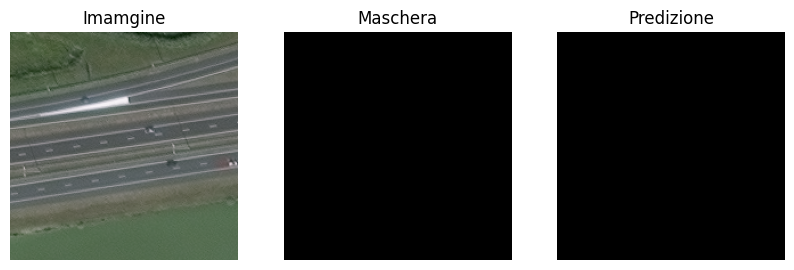

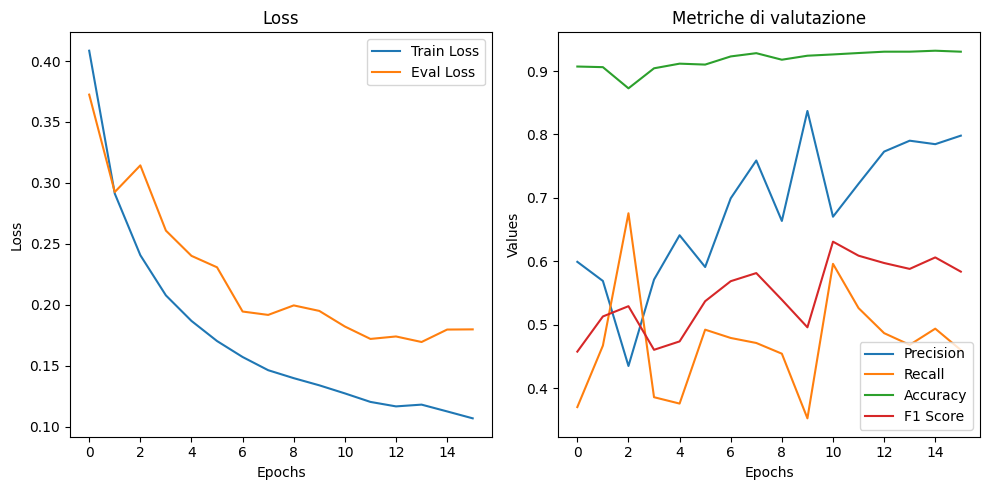

In [ ]:
import matplotlib.pyplot as plt

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)
    
    # Visualizzazione di un esempio di predizione e ground truth
    history = utils.load_checkpoint(CHECKPOINT_PATH + "checkpoint.pth", model)
    image, mask, pred = utils.get_random_image(eval_loader, model, device)
    utils.visualize_image(image.cpu(), mask.cpu(), pred.cpu(), save_path = GRAPH_PATH + "esempio.png")

    train_loss = history['train_loss']
    eval_loss = history['val_loss']
    precision = history['precision']
    recall = history['recall']
    accuracy = history['accuracy']
    f1_score = history['f1']
    # Grafico della loss e delle altre metriche di valutazione
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Loss')   
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(train_loss, label='Train Loss')
    plt.plot(eval_loss, label='Eval Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Metriche di valutazione')
    plt.xlabel('Epochs')
    plt.ylabel('Values')
    plt.plot(precision, label='Precision')
    plt.plot(recall, label='Recall')
    plt.plot(accuracy, label='Accuracy')
    plt.plot(f1_score, label='F1 Score')
    plt.legend()
    plt.tight_layout()
    plt.savefig(GRAPH_PATH + "grafico.png")
    plt.show()

Da tutti gli esperimenti svolti finora, il modello migliore risulta essere il seguente. Gli addestramenti a partire da UNET_6 saranno con questi parametri e cambierò solamente le tecniche di data Augmentation per vedere quali risultano migliori e vanno ad aumentare più possibile l'F1-score, che è la metrica di maggiore interesse.


In [ ]:
# --- INIZIO RUN: UNET_O ---
# Config: MODEL_NAME=UNET_O,NETWORK_TYPE=UNET,IN_CHANNELS=3,OUT_CHANNELS=1,LR=0.0001,BATCH_SIZE=16,OPTIMIZER=Adam,LOSS_FUNCTION=BCEWithLogitsLoss,MAX_EPOCHS=16
# Stats: TRAIN_LOSS=0.0820,VAL_LOSS=0.1536,BEST_F1=0.7289,PRECISION=0.7670,RECALL=0.6944,ACCURACY=0.9454,EPOCH_OF_BEST_F1=10
# --- FINE RUN: UNET_O ---



In [ ]:
# Data augmentation di UNET_O
'''
train_transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    A.RandomResizedCrop(size = (SIZE, SIZE)),
])
'''

# Data augmentation di UNET_6
''' 
train_transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    A.RandomResizedCrop(size = (SIZE, SIZE)),
    # Aggiunta di rotazioni e flipping
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
])
'''



' \ntrain_transforms = A.Compose([\n    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),\n    A.RandomResizedCrop(size = (SIZE, SIZE)),\n    # Aggiunta di rotazioni e flipping\n    A.HorizontalFlip(p=0.5),\n    A.VerticalFlip(p=0.5),\n    A.RandomRotate90(p=0.5),\n])\n'